# Boardgame Recommender


## 1. Business Understanding

**BoardGameGeek** is a comprehensive online database that consists of over 125,600 board games, providing access to reviews, discussion forums, and detailed information on individual titles. It is widely recognized as the most extensive repository of board game data available. In addition to serving as an information resource, the platform enables users to rate games on a 1–10 scale and to manage their personal game collections.

The goal of this project is to develop a recommender system that leverages data from BoardGameGeek to suggest board games to users. We chose a matrix factorization collaborative filtering approach, using community rating data to learn latent features of users and games. The system generates personalized recommendations for a selected user, based on their past ratings.

In [103]:
# Target user
target_user = "TeemuVataja"

## 2. Data Understanding

The dataset used in this project is the **Board Game Database** available on [Kaggle](https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek), which compiles data from the **BoardGameGeek (BGG)** platform. The data, collected in 2021, captures detailed information about board games, their attributes, and user interactions on the site. 

This dataset provides a rich foundation for exploring patterns in board game design, user preferences, and popularity, making it well-suited for building a **recommender system** based on user ratings and item similarities.

### 2.1 Overview of Available Files

The dataset consists of **nine files**, each offering different dimensions of board game data:

- **GAMES** – Contains core details for approximately **22,000 board games** with **47 features**.  
  Each game is identified by a unique **BGGId**, serving as the primary key. This file includes metadata such as publication year, minimum/maximum players, average playtime, and average user rating.

- **RATINGS_DISTRIBUTION** – Provides the **full rating distribution** for each game (`BGGId`), detailing how users rated the game on a 1–10 scale.

- **THEMES** – Lists **thematic categories** associated with each game (`BGGId`), allowing thematic-based filtering and analysis.

- **MECHANICS** – Includes **game mechanics** represented as binary indicators per game, enabling insights into gameplay styles (e.g., deck building, worker placement, area control).

- **SUBCATEGORIES** – Contains **secondary classifications** (binary flags) that describe additional attributes or gameplay aspects of each title.

- **ARTISTS_REDUCED** – Identifies **artists** involved in the visual design of each game.  
  Only artists with more than 3 works are included explicitly; others are represented by a binary flag.

- **DESIGNERS_REDUCED** – Provides information about **game designers**, using the same filtering logic as the artists file (designers with >3 works listed individually).

- **PUBLISHERS_REDUCED** – Contains **publisher information** with binary flags for those associated with fewer than 3 published games.

- **USER_RATINGS** – The largest and most critical table for recommendation modeling.  
  It contains user-generated ratings with over **411,000 unique users** and approximately **19 million ratings**, linking users to the games they have rated via `username` and `BGGId`.

### 2.2 Data Relevance to the Project

For this project, the **USER_RATINGS** dataset forms the foundation of the **item-based collaborative filtering** recommender system.

### 2.3 Data Source

- **Primary Source:** [BoardGameGeek](https://boardgamegeek.com/)  
- **Dataset Repository:** [Board Games Database on Kaggle](https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek)

### 2.4 Data Access and Loading

To begin the analysis, the dataset is retrieved directly from **Kaggle** using the `kagglehub` library.  
This ensures easy and reliable access to the **Board Game Database** for exploration and modeling.

Install dependencies as needed:  
`pip install kagglehub[pandas-datasets]`

In [104]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("threnjen/board-games-database-from-boardgamegeek")

### 2.5 Exploring the `GAMES` File

The **`games.csv`** file serves as the **master information table**, containing detailed metadata for each board game listed on BoardGameGeek.  
Each game is uniquely identified by the `BGGId` and described using 47 attributes covering gameplay, community ratings, rankings, and publisher information.

Key features include:

- **BGGId** – Unique BoardGameGeek game identifier  
- **Name** – Title of the board game  
- **Description** – Lemmatized and punctuation-stripped description text  
- **YearPublished** – Year the game was first published  
- **GameWeight** – Difficulty or complexity rating  
- **AvgRating / BayesAvgRating** – Average and Bayesian-weighted average user ratings  
- **MinPlayers / MaxPlayers / BestPlayers** – Recommended and community-voted player counts  
- **ComAgeRec / MfgAgeRec** – Community and manufacturer age recommendations  
- **MfgPlayTime / ComMinPlaytime / ComMaxPlaytime** – Estimated and community-reported play times  
- **NumOwned / NumWant / NumWish** – Ownership and wishlist statistics  
- **Rank:** fields – Game rankings across multiple categories (e.g., strategy, thematic, party)  
- **Cat:** fields – Binary indicators for major game categories  

The following code loads the `games.csv` file into a pandas DataFrame and displays the first few records for inspection.

In [105]:
df_games = pd.read_csv(os.path.join(path, "games.csv"))
display(df_games.head())

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,21926,0,1,0,0,0,0,0,0
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,...,21926,21926,0,0,0,0,0,0,0,0
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,...,21926,21926,0,1,0,0,0,0,0,0


### 2.7 Exploring the `USER_RATINGS` File

The **`user_ratings.csv`** file captures individual user ratings for board games listed on BoardGameGeek.  
Each record links a **user** to a **game** through its unique `BGGId` and the corresponding numeric rating, forming the foundation for collaborative filtering–based recommendations.

Key features include:

- **BGGId** – Unique identifier for each board game (foreign key referencing the `GAMES` table)  
- **Rating** – The raw user-assigned rating on a 1–10 scale  
- **Username** – Identifier of the user who provided the rating  

This dataset contains over **19 million ratings** from approximately **411,000 unique users**, making it the **core interaction data** for the recommender system.

The following code loads the `user_ratings.csv` file into a pandas DataFrame and displays the first few records to examine its structure.

In [106]:
df_user_ratings = pd.read_csv(os.path.join(path, "user_ratings.csv"))
display(df_user_ratings.head())

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


### 2.6 Data Quality Assessment

A thorough assessment of data quality was conducted to ensure the dataset is suitable for analysis and modeling.  
This evaluation focused on two key aspects: **missing values** and **outliers**.  
The findings are based on the official dataset documentation provided on Kaggle:  
[Board Games Database (BoardGameGeek, Kaggle)](https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek?select=games.csv)

#### Missing Values
- The **`games.csv`** file was found to be **largely complete**, with **only one missing value** detected in the `Description` column.  
  Since this column contains textual metadata and is not critical for the recommendation system, this missing entry does not pose a problem for the analysis.
- The **`user_ratings.csv`** file contains **no missing values**, ensuring the user–item interaction data is fully populated and ready for modeling.

#### Outliers
- Based on both the exploratory inspection and the accompanying dataset documentation, the **`games.csv`** file contains **no outlier values** in its numerical attributes (e.g., `AvgRating`, `GameWeight`, or `NumUserRatings`).
- The **`user_ratings.csv`** file also shows **no outliers**, with all ratings conforming to the expected **1–10** user rating scale.

Overall, both datasets demonstrate **excellent data quality**, requiring minimal cleaning prior to the development of the recommender system.

### 2.7 Visualizing the data

Here, we display key elements that are the focus of this project, primarily the ratings distribution. A normal distribution curve is also shown for reference. We first present data for all users, followed by data for the target user.

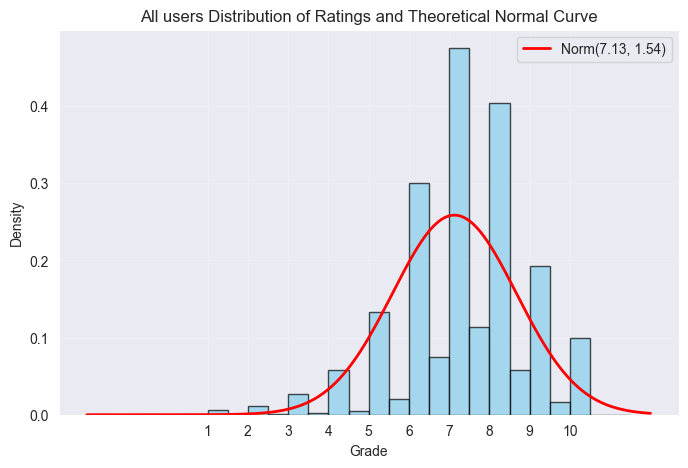

Information for: All users
Mean: 7.13, Standard deviation: 1.54


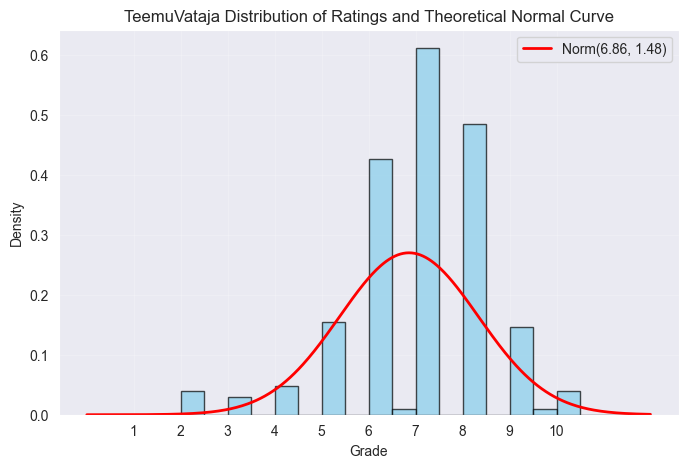

Information for: TeemuVataja
Mean: 6.86, Standard deviation: 1.48


In [107]:
import matplotlib.pyplot as plt
from scipy.stats import norm


def create_distribution_histogram(title,user_data):
    bin_width = 0.5
    bins = np.arange(1, 10+2, bin_width)
    mu = np.mean(user_data) 
    sigma = np.std(user_data, ddof=0) 
    
    #plot histogram 
    plt.figure(figsize=(8,5))
    plt.hist(
        user_data,
        bins=bins,
        density=True,
        color='skyblue',
        edgecolor='black',
        alpha=0.7
    )    
    # Draw theoretical normal distribution 
    x = np.linspace(min(user_data)-2, max(user_data)+2, 400)
    pdf = norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, color='red', linewidth=2, label=f'Norm({mu:.2f}, {sigma:.2f})') 
    # Set titles and legends 
    plt.title(f'{title} Distribution of Ratings and Theoretical Normal Curve') 
    plt.xticks(range(1, 11)) 
    plt.xlabel('Grade') 
    plt.ylabel('Density') 
    plt.legend() 
    plt.grid(alpha=0.2) 
    plt.show() 
    print(f"Information for: {title}") 
    print(f"Mean: {mu:.2f}, Standard deviation: {sigma:.2f}")
   




all_users_data = df_user_ratings["Rating"]
create_distribution_histogram("All users",all_users_data)

user_data = df_user_ratings[df_user_ratings["Username"] == target_user]["Rating"]
create_distribution_histogram(target_user,user_data)

## 3. Data Preparation


User table is consisted with combined data from ratings. Rating count is added to give information how many ratings user has made.

In [108]:
from surprise import Reader, Dataset

# Example df_user_ratings has columns: Username, Item, Rating

# Build user table with unique IDs and rating counts
# If we ever need a dataframe without ratings just copy df_users before this step
df_users = (
    df_user_ratings.groupby("Username")
    .size()  # counts ratings per user
    .reset_index(name="RatingCount")
    .reset_index(names="UserId")  # create UserId from row index
)

print("User table")
display(df_users.head())

print("User rating table")
display(df_user_ratings.head())

print("Selected user table")
display(df_users[df_users["Username"] == target_user])

User table


,UserId,Username,RatingCount
0,0,Fu_Koios,2
1,1,beastvol,9
2,2,mycroft,14
3,3,woh,5
4,4,(mostly) harmless,1


User rating table


,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


Selected user table


,UserId,Username,RatingCount
187874,187874,TeemuVataja,206


Next, users with less than  10 ratings are filtered out from the data to later reduce the amount of user reviews.


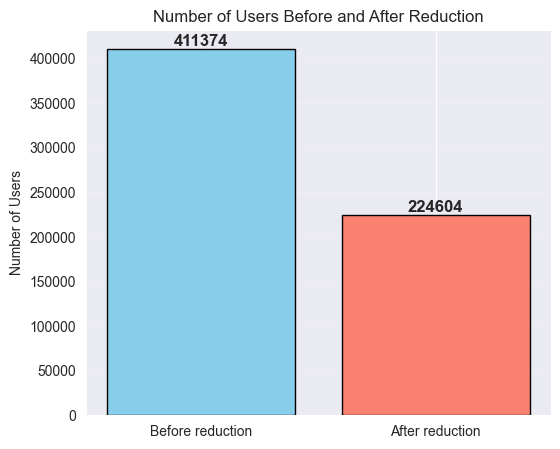

In [109]:
df_users_reduced = df_users[df_users['RatingCount'] >= 10]

# Examples
before = len(df_users)
after = len(df_users_reduced)

# Data and labels
counts = [before, after]
labels = ['Before reduction', 'After reduction']

# Plot diagram
plt.figure(figsize=(6,5))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon'], edgecolor='black')

# Add numbers to on top of bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Number of Users')
plt.title('Number of Users Before and After Reduction')
plt.grid(axis='y', alpha=0.2)
plt.show()

We also filter out games less than 100 reviews. These wouldn't be likely recommendations anyway, so we increase efficiency by not having to predict ratings for these.


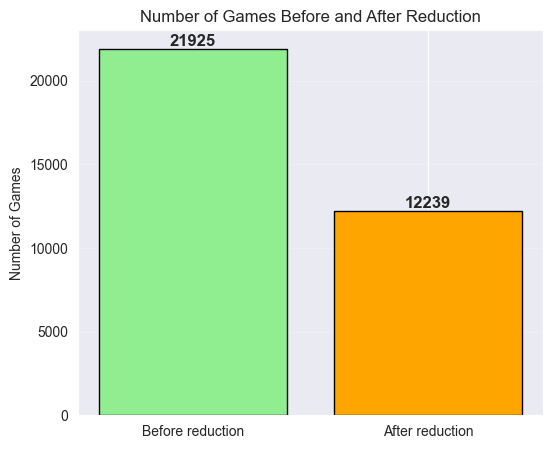

In [110]:
df_games_reduced = df_games[df_games['NumUserRatings'] >= 100]

import matplotlib.pyplot as plt

# Examples
before = len(df_games)
after = len(df_games_reduced)

# Data and labels
counts = [before, after]
labels = ['Before reduction', 'After reduction']

# Plot diagram
plt.figure(figsize=(6,5))
bars = plt.bar(labels, counts, color=['lightgreen', 'orange'], edgecolor='black')

# Add numbers to on top of bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Number of Games')
plt.title('Number of Games Before and After Reduction')
plt.grid(axis='y', alpha=0.2)
plt.show()

Here we can see how little reducing users and games affected to ratings count. Even though the amount of users and games are reduced to almost half, this only removed approximately 5% of data rows from the reviews table. This is expected as we are left with the most popular games and the most active users.


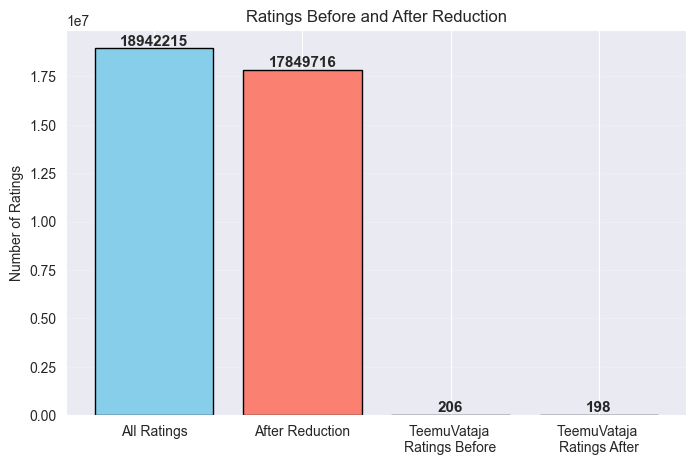

In [111]:
df_ratings_reduced = df_user_ratings[df_user_ratings["BGGId"].isin(df_games_reduced["BGGId"])]
df_ratings_reduced = df_ratings_reduced[df_ratings_reduced["Username"].isin(df_users_reduced["Username"])]

before = len(df_user_ratings)
after = len(df_ratings_reduced)
target_user_count_before = len(df_user_ratings[df_user_ratings['Username'] == target_user])
target_user_count_after = len(df_ratings_reduced[df_ratings_reduced['Username'] == target_user])

# Data and labels
counts = [before, after, target_user_count_before, target_user_count_after]
labels = ['All Ratings', 'After Reduction', f'{target_user} \nRatings Before',  f'{target_user} \nRatings After']

# Plot diagram
plt.figure(figsize=(8,5))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen', 'orange'], edgecolor='black')

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Number of Ratings')
plt.title('Ratings Before and After Reduction')
plt.grid(axis='y', alpha=0.2)
plt.show()


## 4. Modeling


For handling our data we had two options;

SVD
KNN

We initially envisioned using kNN algorithm to calculate user preferences. This would have been preferable as kNN algorithm is very transparent in creating connections by calculating distances between different points. This however soon turned out to be impossible as our dataset was simply too large for such algorithm; instead we decided to go with SVD algorithm which instead of calculating distances attempts to find latent factors in our data that can then be used to predict new values.

In [112]:
from surprise import SVD, dump
import os

def create_surprise_dataset(df, user_id, item_id, ratings, reader):
    return Dataset.load_from_df(df[[user_id, item_id, ratings]], reader)

data = create_surprise_dataset(df_ratings_reduced, "Username", "BGGId", "Rating", Reader(rating_scale=(0.0, 10.0)))

In [113]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def top_similar_users(username, model, top_n=10):
    try:
        inner_uid = model.trainset.to_inner_uid(username)
    except ValueError:
        return []

    # 1. Get given user's latent vector, reshaped into 2D
    #    model.pu[id] is (n_users, n_factors)
    #    Need one user, many factors to calculate cosine_similarity
    user_vec = model.pu[inner_uid].reshape(1, -1)
    
    # 2. Calculate cosine similarity between user and all other users
    sims = cosine_similarity(user_vec, model.pu)[0]

    # 3. Exclude self
    top_inner = np.argsort(-sims)[1:top_n+1]
    
    # 4. Convert all back into normal usernames
    return [model.trainset.to_raw_uid(i) for i in top_inner]

In the above function we give the username for which we find top N similar users. Factorizing the model into two latent vectors:

model.pu = User latent vector

model.qi = Item latent vector

Using vector of model.pu we can get the top N users which have the most similar player profile to our target user.

In [114]:
def user_predictions_from_similar(username, model, top_n_users=1000, top_n_items=10):

    # 1. Fetch top N similar users
    similar_users = top_similar_users(username, model, top_n=top_n_users)

    # 2. Collect items that have been rated by the users ruled as most similar to our target
    similar_items = set()
    for su in similar_users:
        inner_uid = model.trainset.to_inner_uid(su)
        similar_items.update([model.trainset.to_raw_iid(iid) for (iid, _) in model.trainset.ur[inner_uid]])

    # 3. Filter out items already rated by target user
    inner_uid_target = model.trainset.to_inner_uid(username)
    user_items = {model.trainset.to_raw_iid(iid) for (iid, _) in model.trainset.ur[inner_uid_target]}
    candidate_items = similar_items - user_items

    # 4. Build test set and predict
    testset = [(username, iid, 0.) for iid in candidate_items]
    predictions = model.test(testset)
    predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n_items]

    return predictions


After retrieving N most similar users as in the function above we can use these to predict similar results our user might give.


## 5. Evaluation

The performance of the recommendation model in this project is evaluated using **cross-validation**.  
Specifically, the `cross_validate` function from the `surprise.model_selection` module is employed to assess the **SVD (Singular Value Decomposition)** model.

In this setup, the SVD model is configured with 50 latent factors (`n_factors=50`) and a fixed random seed (`random_state=666`) to ensure reproducibility.  
A three-fold cross-validation (`cv=3`) is performed, meaning the dataset is divided into three equal parts. In each iteration, two-thirds of the data are used to train the model, while the remaining one-third is used for testing.  

Model performance is measured using two key metrics: **Root Mean Square Error (RMSE)** and **Mean Absolute Error (MAE)**. These metrics are computed for both the training and test sets (`return_train_measures=True`), allowing us to evaluate not only how well the model fits the data it was trained on, but also how effectively it generalizes to unseen data.  

Overall, this evaluation approach provides a reliable estimate of the model’s predictive accuracy and its ability to generalize beyond the training data.

In [115]:
from surprise.model_selection import cross_validate

results = cross_validate(
    SVD(n_factors=5, random_state=666),
    data, measures=["RMSE", "MAE"],
    cv=3,
    return_train_measures=True,
    verbose=True
)

results_df = pd.DataFrame(results)
results_df

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1468  1.1464  1.1464  1.1465  0.0002  
MAE (testset)     0.8566  0.8560  0.8558  0.8561  0.0003  
RMSE (trainset)   1.0735  1.0727  1.0735  1.0732  0.0004  
MAE (trainset)    0.8055  0.8042  0.8051  0.8049  0.0005  
Fit time          70.74   68.64   69.44   69.61   0.86    
Test time         41.25   29.32   42.94   37.84   6.06    


,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
0,1.146801,1.073491,0.856574,0.805526,70.736696,41.253386
1,1.146393,1.072731,0.856028,0.804204,68.642778,29.318018
2,1.146350,1.073475,0.855813,0.805067,69.440126,42.940376


### Understanding the Performance Metrics

#### **Root Mean Square Error (RMSE)**  

   $$RMSE = \sqrt{\frac{1}{N} \sum_{(u,i)} (\hat{r}_{ui} - r_{ui})^2}$$  

RMSE measures the square root of the average squared difference between predicted and actual ratings.

Because the errors are **squared before averaging**, RMSE gives **more weight to larger errors** — meaning a few big mistakes will increase this value significantly.  

For board game recommendation systems using a **1–10 rating scale**, typical RMSE values range from **1.0 to 2.0**:  
- **< 1.0** → Excellent predictive performance  
- **1.0–1.5** → Good, typical for collaborative filtering models  
- **> 2.0** → Poor, indicating weak predictive accuracy or sparse data  

A **lower RMSE** means the model’s predictions are generally close to actual ratings, while a higher value suggests inconsistent or inaccurate predictions. 

RMSE is especially useful when you want to **penalize large errors**, such as recommending something that a user would really dislike.

    
#### **Mean Absolute Error (MAE)**
 
   $$MAE = \frac{1}{N} \sum_{(u,i)} |\hat{r}_{ui} - r_{ui}|$$  

MAE represents the **average absolute difference** between predicted and actual ratings, treating all errors equally.  
It is more **robust to outliers** and easier to interpret: it tells you, on average, how far your predictions are from the true ratings.  

For the same 1–10 scale, **MAE** values are typically **slightly lower than RMSE**:  
- **< 1.0** → Very good accuracy  
- **1.0–1.5** → Acceptable, common for many recommenders  
- **> 1.5** → Mediocre, suggesting inconsistent predictions  

A **lower MAE** indicates more stable and reliable performance overall.

In [116]:
# Display mean performance metrics for quick summary
mean_results = results_df.mean().rename("Mean Value")
mean_results[['test_rmse', 'train_rmse', 'test_mae', 'train_mae']]


test_rmse     1.146515
train_rmse    1.073232
test_mae      0.856138
train_mae     0.804932
Name: Mean Value, dtype: float64

## 6. Deployment


Here, we build the model using the full dataset. First, we define a function to save the trained model as a dump file. This allows us to reload the model in future runs of the notebook, without retraining. The function also checks if a saved model already exists and loads it if available.


In [117]:
# Train model with full dataset and save, load from disc if available
def load_surprise_model(model_name, algo, force_recreate=False):
    
    # If model doesn't exist, train new model
    if not os.path.exists(model_name) or force_recreate:
        
        # Read dataset
        surprise_dataset = create_surprise_dataset(df_ratings_reduced, "Username", "BGGId", "Rating", Reader(rating_scale=(0.0, 10.0))) 
        
        # Build training set from full data
        surprise_trainset = surprise_dataset.build_full_trainset()
        
        # Create the model with the full dataset
        algo.fit(surprise_trainset)
        
        # Save model as .pkl file
        dump.dump(model_name, algo=algo)
        
        # Return model
        return algo

    # If model exists, load model from file
    _, algo = dump.load(model_name)
    
    # Return model
    return algo

# Model creation using the function
model = load_surprise_model("model.pkl", SVD(n_factors=5,random_state=666))


After creating the model, we will calculate predictions for the selected user.

The top 10 results for the user are then displayed.

In [118]:
# Get predictions for selected user
predictions = user_predictions_from_similar(target_user, model)

# Sort and print the predictions
top10 = sorted(predictions, key=lambda x: x.est, reverse=True)
for pred in top10:
    print(f"Predicted rating for item id {pred.iid}: {pred.est:.2f}")
    display(df_games_reduced.loc[df_games_reduced["BGGId"] == pred.iid, ["BGGId", "Name", "AvgRating"]])

Predicted rating for item id 55690: 9.18


,BGGId,Name,AvgRating
9398,55690,Kingdom Death: Monster,8.61012


Predicted rating for item id 342942: 9.17


,BGGId,Name,AvgRating
21896,342942,Ark Nova,8.47839


Predicted rating for item id 323947: 8.96


,BGGId,Name,AvgRating
21631,323947,Middara: Unintentional Malum – Act 1 Version 1.1,9.02596


Predicted rating for item id 248562: 8.93


,BGGId,Name,AvgRating
18640,248562,Mage Knight: Ultimate Edition,8.94937


Predicted rating for item id 162886: 8.91


,BGGId,Name,AvgRating
13755,162886,Spirit Island,8.3583


Predicted rating for item id 233078: 8.91


,BGGId,Name,AvgRating
17834,233078,Twilight Imperium: Fourth Edition,8.67916


Predicted rating for item id 295785: 8.90


,BGGId,Name,AvgRating
20830,295785,Euthia: Torment of Resurrection,8.87023


Predicted rating for item id 299659: 8.85


,BGGId,Name,AvgRating
20987,299659,Clash of Cultures: Monumental Edition,8.62371


Predicted rating for item id 115746: 8.83


,BGGId,Name,AvgRating
11220,115746,War of the Ring: Second Edition,8.50988


Predicted rating for item id 278292: 8.83


,BGGId,Name,AvgRating
20109,278292,Anachrony: Infinity Box,9.07609


### Personal opinions on predicted ratings
As this model was trained using my personal board game ratings on boardgamegeek.com, I can slightly evaluate the quality of the recommendations. Since the rating data for the dataset was collected 4 years ago, I have actually rated some of the recommended games since:  


| Name              | Predicted rating | Actual rating |
|-------------------|-----------------:|--------------:|
| Ark Nova          |              9.17 |             9 |
| Mage Knight       |              8.93 |             7 |
| Spirit Island     |              8.91 |             9 |
| Twilight Imperium |              8.91 |            10 |

These are surprisingly close. Also for the games I have not rated, I can see the reasoning with each of them.

### Model Integration and Applications

The final model could be integrated into various platforms.  
If an initial data input stage were added, the model could be used even without requiring an existing user on the site.

**Possible applications include:**
- Web store plugins  
- A standalone app  

**Future improvements:**
- Use updated data scraped via the *BoardGameGeek XML API*  
- Deploy as a backend API service  